In [1]:
import sys
sys.path.insert(0, '../scripts/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import required packages
import numpy as np
import pandas as pd

# encoders
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# models
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 

# metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import recall_score, roc_auc_score

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# local scripts
from text_utils import preprocess_corpus

In [3]:
# load train, validation and test sets into dataframe
df_train = pd.read_csv('../data/train_data.csv')
df_valid = pd.read_csv('../data/valid_data.csv')
df_test = pd.read_csv('../data/test_data.csv')

# combine train and validation sets
# shuffle dataframe randomly
df_train = pd.concat([df_train, df_valid]).sample(frac=1, random_state=42).reset_index(drop=True)

# shape of train and test sets: (rows, columns)
display(df_train.shape, df_test.shape)

(38153, 2)

(9539, 2)

In [4]:
df_train.head()

,tweet_text,cyberbullying_type
0,"Smh... “@tayyoung_: FUCK OBAMA, dumb ass nigger”",ethnicity
1,If one retired army officer does something bru...,religion
2,acting like the nazis didn’t take inspiration ...,age
3,Tje clps on peel scholl dont care abt cyber bu...,age
4,#parents Another key word 4 Bullying Preventio...,not_cyberbullying


In [5]:
# first 5 datapoints of train and test sets
display(df_train.head())
display(df_test.head())

,tweet_text,cyberbullying_type
0,"Smh... “@tayyoung_: FUCK OBAMA, dumb ass nigger”",ethnicity
1,If one retired army officer does something bru...,religion
2,acting like the nazis didn’t take inspiration ...,age
3,Tje clps on peel scholl dont care abt cyber bu...,age
4,#parents Another key word 4 Bullying Preventio...,not_cyberbullying


,tweet_text,cyberbullying_type
0,@Goree_JuhssGuns hahaha he ain't even worth my...,ethnicity
1,RT @hsaymssik: Sucks to have the smile wiped o...,gender
2,"Just a reminder, it's absolutely disgusting to...",ethnicity
3,RT @BuzzFeedUK: When you accidentally open you...,other_cyberbullying
4,Loving the look of the fritters! #mkr,not_cyberbullying


In [6]:
# extract independent features
# preprocess text column
X_train = preprocess_corpus(df_train.tweet_text)
X_test = preprocess_corpus(df_test.tweet_text)

# size of train & test sets
display(X_train.shape, X_test.shape)

(38153,)

(9539,)

In [7]:
# first 5 preprocessed tweets of train & test sets
display(X_train.head())
display(X_test.head())

0                  smh tayyoung fuck obama dumb nigger
1    one retired army officer something brutal whol...
2    act like nazi take inspiration gas chamber use...
3    tje clps peel scholl dont care abt cyber bully...
4    parent another key word bully prevention think...
Name: tweet_text, dtype: object

0    goree juhssguns hahaha even worth tweet dumb f...
1    hsaymssik suck smile wiped face huh kat glass ...
2    reminder absolutely disgust see people would p...
3            buzzfeeduk accidentally open front camera
4                                love look fritter mkr
Name: tweet_text, dtype: object

In [8]:
# encode the class labels
# extract dependent features
y_train = df_train.cyberbullying_type
y_test = df_test.cyberbullying_type

# spawn a label encoder
encoder = LabelEncoder()

# train the encoder on the train set labels
encoder.fit(y_train.values.ravel())

# transform the labels
y_train = pd.DataFrame(encoder.transform(y_train.values.ravel()), columns=['cyberbullying_type'])
y_test = pd.DataFrame(encoder.transform(y_test.values.ravel()), columns=['cyberbullying_type'])

# size of train & test set class labels
display(y_train.shape, y_test.shape)

(38153, 1)

(9539, 1)

In [9]:
# first 5 encoded class labels of train & test sets
display(y_train.head())
display(y_test.head())

,cyberbullying_type
0,1
1,5
2,0
3,0
4,3


,cyberbullying_type
0,1
1,2
2,1
3,4
4,3


# Bag of Words Transformation

In [10]:
# bag of words transformation
# instantiate a CountVectorizer
bow_vectorizer = CountVectorizer(min_df=15)

# train and construct bag of words
X_train_bow = pd.DataFrame(bow_vectorizer.fit_transform(X_train).toarray(), columns=bow_vectorizer.get_feature_names_out())
X_test_bow = pd.DataFrame(bow_vectorizer.transform(X_test).toarray(), columns=bow_vectorizer.get_feature_names_out())

# shape of document matrix: (rows, columns)
display(X_train_bow.shape, X_test_bow.shape)

(38153, 3192)

(9539, 3192)

In [11]:
# first 5 datapoints of transformed train & validation sets
display(X_train_bow.head())
display(X_test_bow.head())

,aalwuhaib,abc,ability,able,abortion,absolute,absolutely,abt,abu,abuse,...,yousufpoosuf,youth,youtube,ypg,yrs,yup,zaibatsunews,zappe,zero,zionist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aalwuhaib,abc,ability,able,abortion,absolute,absolutely,abt,abu,abuse,...,yousufpoosuf,youth,youtube,ypg,yrs,yup,zaibatsunews,zappe,zero,zionist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# utility function
# plot confusion matrix using sns heatmap
def plot_confusion_matrix(cf_matrix, title, xlabel='Predicted', ylabel='Actual', ticklabels=None, figsize=(8,4), fontdict={'fontsize':12}):
    
    # extract counts from confusion matrix
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    # calculate proportions from confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    # create annotations for plot
    annotations = [f'{count}\n{percentage}\n'.format(count, percentage) for count, percentage in zip(group_counts, group_percentages)]
    annotations = np.asarray(annotations).reshape(cf_matrix.shape)

    plt.figure(figsize = figsize, dpi=100)
    ax = sns.heatmap(cf_matrix, annot=annotations, fmt='', cmap='Blues')

    # set title
    ax.set_title(title, fontdict=fontdict)
    
    # set axes labels
    ax.set_xlabel(xlabel, fontdict=fontdict)
    ax.set_ylabel(ylabel, fontdict=fontdict)

    # tick labels - List must be in alphabetical order
    if ticklabels:
        # set axes tick labels
        ax.xaxis.set_ticklabels(ticklabels)
        ax.yaxis.set_ticklabels(ticklabels)

    # display the visualization of the confusion matrix.
    plt.show()

# Hyperparameter Tuning: XGBoost

In [13]:
# create a map of params to be optimized
params = {
    'learning_rate': (0.1, 0.3),
    'max_depth': (6, 10),
}

# instantiate a GridSearchCV object with SVM model and params
grid_search_cv = GridSearchCV(XGBClassifier(), params, verbose=4, cv=5) 

# perform grid search
grid_search_cv.fit(X_train_bow, y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....learning_rate=0.1, max_depth=6;, score=0.838 total time= 6.5min
[CV 2/5] END ....learning_rate=0.1, max_depth=6;, score=0.830 total time= 6.4min
[CV 3/5] END ....learning_rate=0.1, max_depth=6;, score=0.834 total time= 6.4min
[CV 4/5] END ....learning_rate=0.1, max_depth=6;, score=0.837 total time= 6.4min
[CV 5/5] END ....learning_rate=0.1, max_depth=6;, score=0.828 total time= 6.3min
[CV 1/5] END ...learning_rate=0.1, max_depth=10;, score=0.843 total time=10.7min
[CV 2/5] END ...learning_rate=0.1, max_depth=10;, score=0.839 total time=10.7min
[CV 3/5] END ...learning_rate=0.1, max_depth=10;, score=0.840 total time=10.7min
[CV 4/5] END ...learning_rate=0.1, max_depth=10;, score=0.844 total time=10.7min
[CV 5/5] END ...learning_rate=0.1, max_depth=10;, score=0.837 total time=10.7min
[CV 1/5] END ....learning_rate=0.3, max_depth=6;, score=0.849 total time= 6.3min
[CV 2/5] END ....learning_rate=0.3, max_depth=6;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': (0.1, 0.3), 'max_depth': (6, 10)},
             verbose=4)

In [14]:
# display the best parameters for XGBoost and the best score
grid_search_cv.best_params_, grid_search_cv.best_score_

({'learning_rate': 0.3, 'max_depth': 10}, 0.8459097875070867)

In [15]:
# instantiate XGBClassifier with best parameters
model = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.3,)

# training start
print('training...')
start_time = time.time()

# train the model
model.fit(X_train_bow, y_train.values.ravel())

# training end
end_time = time.time()
time_to_train = end_time - start_time
print('training completed:', '{:.2f}'.format(time_to_train), 'seconds')

# testing start
print('testing...')
start_time = time.time()

# evaluate the model on test set
y_pred = model.predict(X_test_bow)
y_pred_prob = model.predict_proba(X_test_bow)

# testing end
end_time = time.time()
print('testing completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training...
training completed: 3859.51 seconds
testing...
testing completed: 1.86 seconds


accuracy 0.8333158612013838
recall 0.8346504872831618
f1-score 0.8357947531366786


,F1 Score
age,0.978098
ethnicity,0.986516
gender,0.876601
not_cyberbullying,0.568047
other_cyberbullying,0.650407
religion,0.955099


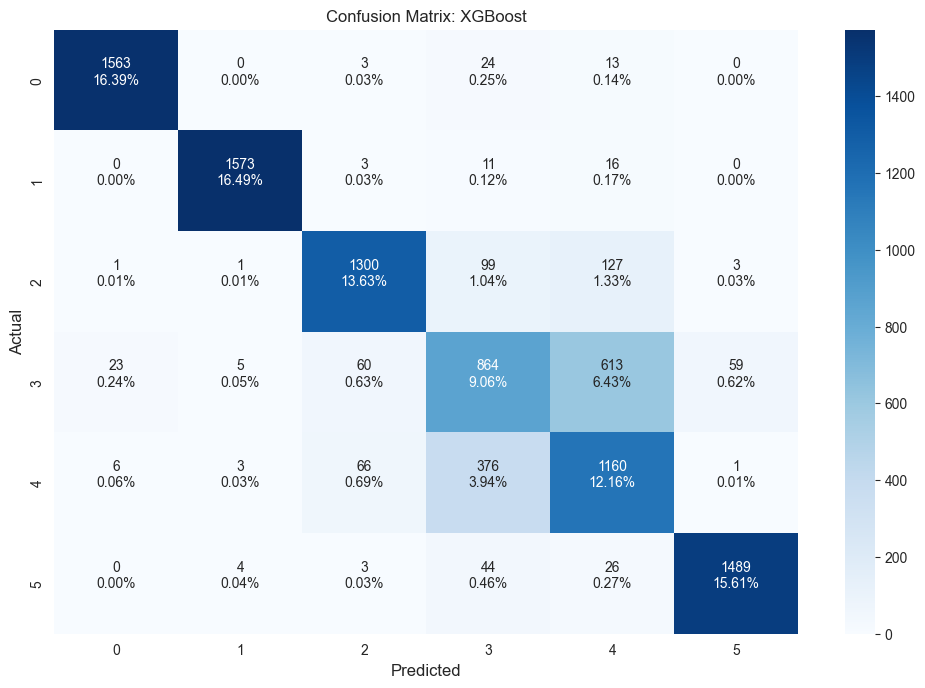

In [32]:
# results: XGBoost
# accuracy
acc = accuracy_score(y_test, y_pred)
# results['XGBoost'].append(acc)
print('accuracy', acc)

# recall
recall = recall_score(y_test, y_pred, average='macro')
# results['XGBoost'].append(recall)
print('recall', recall)

# f1 score
f1 = f1_score(y_test, y_pred, average='macro')
# results['XGBoost'].append(f1)
print('f1-score', f1)

# roc_auc
# roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')
# results['XGBoost'].append(roc)
# print('roc_auc', roc)

# class label-wise f1 score
# 0 - Not Phishing
# 1 - Phishing
display(pd.DataFrame(np.asarray(f1_score(y_test, y_pred, average=None)).T, columns=['F1 Score'], index=encoder.classes_))

# confusion matrix
# plot heatmap
plot_confusion_matrix(
    confusion_matrix(y_test.values.ravel(), y_pred),
    'Confusion Matrix: XGBoost',
    figsize=(12,8)
)